# Investigating correlation between features and tumor stage (linear model)

In [22]:
setwd("/home/data/project_code/landstrom_core/prognostic_model_development/r/notebooks")
library(ggplot2)
library(tidyverse)
source("../getTCGAData.R")
source("../preprocessTCGAData.R")
source("../KM_analysis.R")
source("../Heatmaps.R")
source("../enet.R")
library(ggpubr)
library(rstatix)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.2.1
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.

# Function

In [1]:
#
# Define function for adding the clinical variables 
#
addClinVar = function(data, clin.var) {
    if ("Age.oth" %in% clin.var) {
        data$Age.oth <- data$age_at_diagnosis.clin
    } 
    if ("Tumor.stage.oth" %in% clin.var){
        data$Tumor.stage.oth = factor(map_chr(data$ajcc_pathologic_stage.clin, reformatTumorStage))
    }
    if ("Gender.oth" %in% clin.var){
        data$Gender.oth <- factor(data$gender.clin)    
    } 
    if ("Gleason.group.oth" %in% clin.var) {
        
        # Determine the Gleason group 
        data$Gleason.group.oth = map2_chr(data$primary_gleason_grade.clin, 
                                           data$secondary_gleason_grade.clin, 
                                           determineGleasonGroup)

        # Set up the factor levels 
        data$Gleason.group.oth = factor(data$Gleason.group, 
                                    levels = c("Gleason group 1", "Gleason group 2"))
    }
    return(data)
}

# Recode Tumor stage to numeric
recodeTumorStageToNumeric = function(x){
    x.recoded = recode_factor(x, `Stage 1` = 1, `Stage 2` = 2, `Stage 3` = 3, `Stage 4` = 4)
    x.recoded = as.numeric(as.character(x.recoded))
    return(x.recoded)
}

In [3]:
# Read in the table including the clinical features for each cancer type
clin.feat.tb = read.table("/lustre/projects/landstrom_core/data/clin_features_final.csv", sep = "\t", header = T)

# Ensembl id mapping file 
ens.id.mapping = "/home/organisms/Human/hg38/Homo_sapiens.GRCh38_March2022/ENSEMBLE_to_SYMBOL.csv"

# Input dir data 
input.dir.data.path = file.path("/lustre/projects/landstrom_core/data/rdata_revised/manuscript_work")

# Output directory
dir.res.root = file.path("/lustre/projects/landstrom_core/results/Features_vs_tumor_stage_revised/")
dir.create(dir.res.root)

# Gene list  
gene.list.file = read.table("/lustre/projects/landstrom_core/data/Customer_genes.tsv", 
                            sep = "\t", header = F)
gene.list = gene.list.file$V1

# Prepare boxplots and test for significance

Output dir :

In [5]:
# Output dir :
boxplt.results.dir = file.path(dir.res.root, "Features_and_tumor_stage_boxplots/lm")
dir.create(boxplt.results.dir, recursive = T)

In [5]:
# Store all statistical test results to a table 
stat.results.ls = list()

In [6]:
calcCorr = function(x, y){
    res = cor.test(x, y)
    return(data.frame("Corr" = res$estimate, "P.value" = res$p.value))
}

In [6]:
tcga.dataset.test = readRDS(file.path(input.dir.data.path, "BRCA", "tcga.dataset_merged.rds"))

In [8]:
tcga.dataset.test2 = readRDS(file.path(input.dir.data.path, "CESC", "tcga.dataset_merged.rds"))

In [9]:
tcga.dataset.test3 = readRDS(file.path(input.dir.data.path, "PRAD", "tcga.dataset_merged.rds"))

In [10]:
tcga.dataset.test$PFI$train[1:5,1:5]

,Participant.ID,submitter_id.clin,created_datetime.clin,prior_malignancy.clin,diagnosis_id.clin
,<chr>,<chr>,<lgl>,<chr>,<chr>
1,TCGA-EW-A1PC,TCGA-EW-A1PC,NA,no,102cd71e-5a56-53f9-acf7-143c23589b1b
2,TCGA-E2-A15T,TCGA-E2-A15T,NA,no,2c4bdf9f-2f94-5839-ba9b-9cd5c3ade9c1
3,TCGA-A8-A06Q,TCGA-A8-A06Q,NA,no,24899a2b-aec3-592a-88d5-73c70d616750
4,TCGA-AO-A0JI,TCGA-AO-A0JI,NA,no,55f24ee5-2989-5fbc-8c50-80f9b5d82e2b
5,TCGA-E2-A15I,TCGA-E2-A15I,NA,no,2c1064d8-64d7-5fc7-aa57-a6a58e08f896


In [11]:
tcga.dataset.test$DFI$train[1:5,1:5]

,Participant.ID,submitter_id.clin,created_datetime.clin,prior_malignancy.clin,diagnosis_id.clin
,<chr>,<chr>,<lgl>,<chr>,<chr>
1,TCGA-EW-A1PC,TCGA-EW-A1PC,NA,no,102cd71e-5a56-53f9-acf7-143c23589b1b
2,TCGA-E2-A15T,TCGA-E2-A15T,NA,no,2c4bdf9f-2f94-5839-ba9b-9cd5c3ade9c1
3,TCGA-A8-A06Q,TCGA-A8-A06Q,NA,no,24899a2b-aec3-592a-88d5-73c70d616750
4,TCGA-AO-A0JI,TCGA-AO-A0JI,NA,no,55f24ee5-2989-5fbc-8c50-80f9b5d82e2b
5,TCGA-E2-A15I,TCGA-E2-A15I,NA,no,2c1064d8-64d7-5fc7-aa57-a6a58e08f896


In [7]:
final.results = list()
i = 1
for (cancer.type in clin.feat.tb$Ctype){
    
    # Get Clinical variables
    clin.var = unlist(strsplit(clin.feat.tb$Features[clin.feat.tb$Ctype == cancer.type], split = ","))
    
    # Add oth-suffix 
    clin.var = paste0(clin.var, ".oth")
    
    #
    #
    #
    
    # Read in the preprocessed dataset if continued 
    tcga.dataset = readRDS(file.path(input.dir.data.path, cancer.type, "tcga.dataset_merged.rds"))
    
    # Add clinical variables to dataset
    tcga.dataset = addClinVar(tcga.dataset, clin.var)
    
    # Selected variables 
    variables.selected = c(paste0(gene.list, ".exp"), "Tumor.stage.oth")
    
    # Selected variables         
    data.selected.exp = tcga.dataset %>% 
                        dplyr::select(one_of(variables.selected))
    
    if ("Tumor.stage.oth" %in% colnames(data.selected.exp)){
        
        # Recode the tumor stage 
        data.selected.exp$Tumor.stage.oth = recodeTumorStageToNumeric(data.selected.exp$Tumor.stage.oth)
        
        # Calculate correlation and p-value 
        res.ls = list()
        for (j in 1:ncol(data.selected.exp)){
            if (colnames(data.selected.exp[j]) != "Tumor.stage.oth"){
                var1 = data.selected.exp[,j]
                var2 = data.selected.exp$Tumor.stage.oth
                res.ls[[colnames(data.selected.exp[j])]] = calcCorr(var1, var2)
            }
        
        }
        corr.results = bind_rows(res.ls, .id = "Gene")
        final.results[[cancer.type]] = corr.results
    }
}

Warning message:
“Unknown columns: `Tumor.stage.oth`”
Warning message:
“Unknown columns: `Tumor.stage.oth`”
Warning message:
“Unknown columns: `Tumor.stage.oth`”
Warning message:
“Unknown columns: `Tumor.stage.oth`”
Warning message:
“Unknown columns: `Tumor.stage.oth`”
Warning message:
“Unknown columns: `Tumor.stage.oth`”
Warning message:
“Unknown columns: `Tumor.stage.oth`”
Warning message:
“Unknown columns: `Tumor.stage.oth`”
Warning message:
“Unknown columns: `Tumor.stage.oth`”
Warning message:
“Unknown columns: `Tumor.stage.oth`”
Warning message:
“Unknown columns: `Tumor.stage.oth`”
Warning message:
“Unknown columns: `Tumor.stage.oth`”
Warning message:
“Unknown columns: `Tumor.stage.oth`”


TEST WITH KIRP

In [21]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [31]:
clin.var = unlist(strsplit(clin.feat.tb$Features[clin.feat.tb$Ctype == "KICH"], split = ","))

In [51]:
tcga.dataset = readRDS(file.path(input.dir.data.path, "KIRP", "tcga.dataset.rds"))

In [52]:
tcga.dataset$EXP[1:5,1:5]

,Participant.ID,TSPAN6.exp,TNMD.exp,DPM1.exp,SCYL3.exp
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,TCGA-DZ-6131,NA,NA,NA,NA
2,TCGA-B9-7268,4284,1,2333,1013
3,TCGA-B1-A655,4062,0,1681,613
4,TCGA-BQ-7045,1220,0,400,186
5,TCGA-2Z-A9J3,2597,1,1374,546


In [53]:
# Prepare expression matrix 
expression.matrix = tcga.dataset$EXP %>% tibble::column_to_rownames("Participant.ID") %>% as.matrix()

In [58]:
# Select only complete cases 
expression.matrix.complete = expression.matrix[complete.cases(expression.matrix),]

In [60]:
dim(expression.matrix.complete)

[1]   288 56493

In [61]:
expression.matrix.complete = t(expression.matrix.complete)

In [62]:
# Prepare minimal colData with only one condition
coldata = data.frame("Condition" = rep("Condition", ncol(expression.matrix.complete)))
rownames(coldata) = colnames(expression.matrix.complete)

# Generate 
dds = DESeqDataSetFromMatrix(countData = expression.matrix.complete,
                                colData = coldata,
                                design = ~1)

dds = estimateSizeFactors(dds)
dds = estimateDispersions(dds)

# Variance stabilisation function 
vds  = vst(dds, blind = T)

# Get the transformed counts
vst.counts = assay(vds)

converting counts to integer mode

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [70]:
vst.counts.longer = vst.counts %>% as.data.frame() %>% tibble::rownames_to_column("Gene") %>% pivot_longer(-Gene, names_to = "Participant.ID", values_to = "Expression")

In [71]:
head(vst.counts.longer)

Gene,Participant.ID,Expression
<chr>,<chr>,<dbl>
TSPAN6.exp,TCGA-B9-7268,11.63911
TSPAN6.exp,TCGA-B1-A655,11.67784
TSPAN6.exp,TCGA-BQ-7045,11.66209
TSPAN6.exp,TCGA-2Z-A9J3,11.00360
TSPAN6.exp,TCGA-UZ-A9PP,11.71862
TSPAN6.exp,TCGA-UZ-A9PS,12.02103


In [72]:
genes = c("AURKA.exp", "AURKB.exp", "KIF23.exp")

In [73]:
vst.counts.longer.selected = vst.counts.longer %>% dplyr::filter(Gene %in% genes)

In [74]:
vst.counts.longer.selected.with.clin = left_join(vst.counts.longer.selected, tcga.dataset$CLIN)

Joining with `by = join_by(Participant.ID)`


In [75]:
vst.counts.longer.selected.with.clin[1:5,1:5]

Gene,Participant.ID,Expression,submitter_id.clin,year_of_diagnosis.clin
<chr>,<chr>,<dbl>,<chr>,<int>
AURKA.exp,TCGA-B9-7268,8.848548,TCGA-B9-7268,2011
AURKA.exp,TCGA-B1-A655,9.020904,TCGA-B1-A655,2012
AURKA.exp,TCGA-BQ-7045,7.432916,TCGA-BQ-7045,2001
AURKA.exp,TCGA-2Z-A9J3,8.132299,TCGA-2Z-A9J3,2008
AURKA.exp,TCGA-UZ-A9PP,8.111813,TCGA-UZ-A9PP,NA


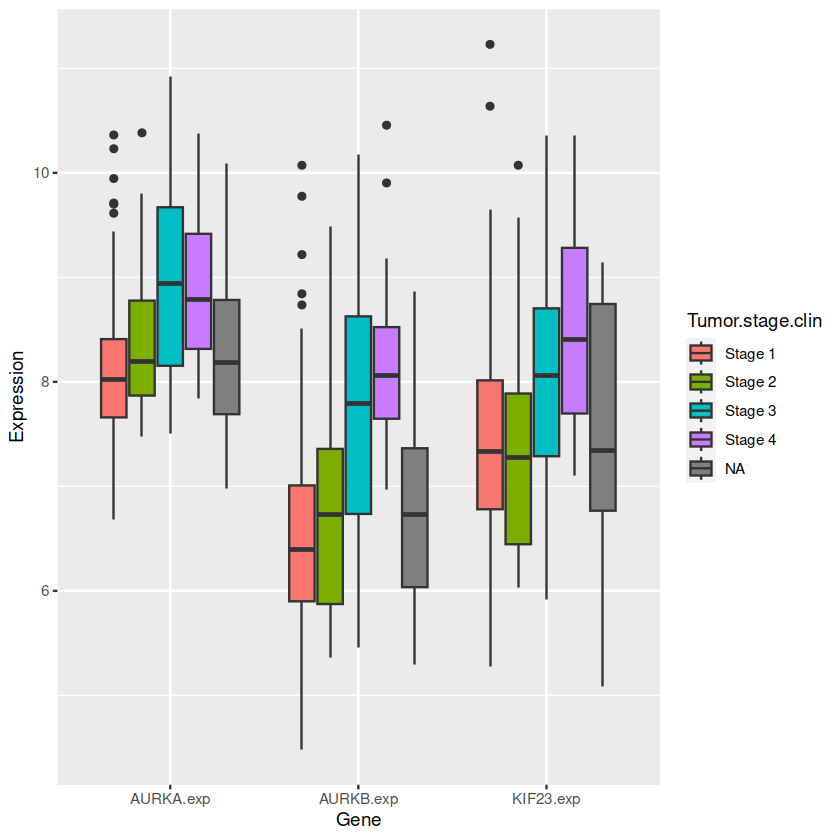

In [78]:
vst.counts.longer.selected.with.clin %>% ggplot(aes(x = Gene, y = Expression, fill = Tumor.stage.clin)) + geom_boxplot()